# APL Custom Artifact 01: Pin Location Errors

Data provided by John Slotwinski on 3/25/2016 ("3D position check.pdf").


In [57]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
%matplotlib inline 

import os, csv

import numpy as np
import pylab as plt
from mpl_toolkits.mplot3d import axes3d, art3d

import helpers as gpam


__author__ = "mjp"
__version__ = "0.0.1"
__status__ = "development"

__copyright__ = "Copyright 2016, JHU/APL"
__license__ = "Apache, Version 2.0"

In [59]:
def load_data(fn):
    """Loads data set from CSV file.
       fn : The .csv file to load.  Format is assumed to be:
            xNominal, xMeasured, yNominal, yMeasured, dNominal, dMeasured, zNominal, zMeasured

            where x, y, d, z are pin x-position, y-position, diameter and height.
            
    Note this data was measured in inches.
    We continue to employ the convention:
         delta_x := x_nominal - X_measured
    """
    X = []  # nominal pin locations
    Xm = [] # measured pin locations
    D = []  # pin location errors (deltas)
 

    cast = lambda row: [row[0].strip(),] + [float(x) for x in row[1:]]

    with open(fn, 'rU') as f:
        reader = csv.reader(f, delimiter=',')
        for rowIdx, row in enumerate(reader):
            if rowIdx == 0: continue # skip header

            pinId, xNom, xMeas, yNom, yMeas, dNom, dMeas, zNom, zMeas = cast(row)
            X.append((xNom, yNom))
            Xm.append((xMeas, yMeas))
            D.append((xNom - xMeas, yNom - yMeas))

    return np.array(X), np.array(Xm), np.array(D)


def plot_pins(Xn, Xm, units='(mm)'):
    plt.figure()
    plt.scatter(Xn[:,0], Xn[:,1], color='magenta')
    plt.scatter(Xm[:,0], Xm[:,1], color='blue')
    plt.legend(['nominal', 'measured'], loc='upper left')
    plt.plot([-52, 52], [0, 0], 'k-')
    plt.plot([0, 0], [-52, 52], 'k-')
    
    plt.xlabel('x location ' + units)
    plt.ylabel('y location ' + units)


In [60]:
Xn, Xm, D = load_data('/Users/pekalmj1/Documents/bb/gpam/data/APL01_M290_Maraging_steel/APL01_pin_features.csv')
assert(Xn.shape[0] == 50)  # there should be 50 pins

np.set_printoptions(formatter={'float_kind': lambda x: "%0.4f" % x})

#print "Nominal Pin locations"
#print Xn
#print "\n\nMeasured Pin locations"
#print Xm


# Convert to metric and calculate polar coordinates
mmPerInch = 25.4
Xn *= mmPerInch
Xm *= mmPerInch
D *= mmPerInch
rN, thetaN = gpam.cart2polar(Xn[:,0], Xn[:,1])  # nominal locations in polar coordinates

## APL01, Trial 1

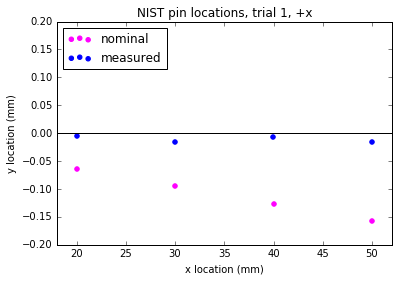

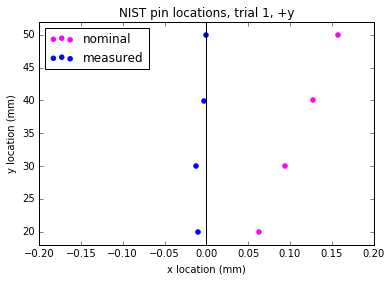

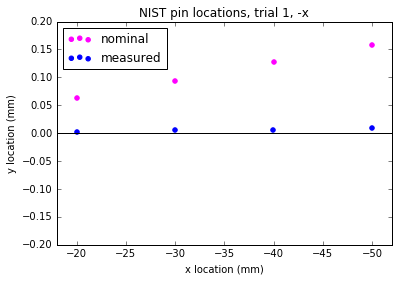

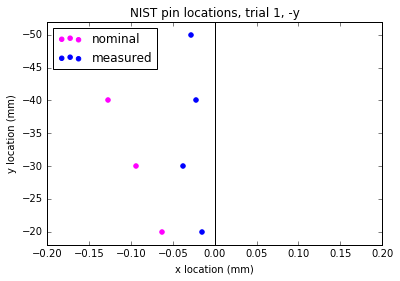

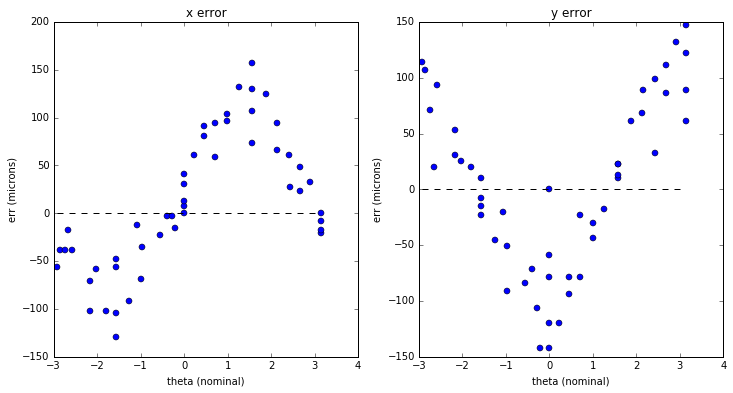

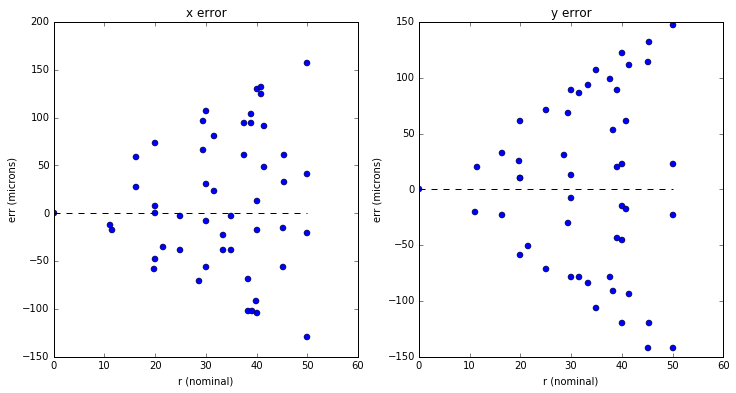

In [61]:
plot_pins(Xn, Xm)
plt.title('NIST pin locations, trial 1, +x')
plt.xlim([18, 52]);  plt.ylim([-.2, .2])

plot_pins(Xn, Xm)
plt.title('NIST pin locations, trial 1, +y')
plt.xlim([-.2, .2]);  plt.ylim([18, 52])

plot_pins(Xn, Xm)
plt.title('NIST pin locations, trial 1, -x')
plt.xlim([-18, -52]);  plt.ylim([-.2, .2])

plot_pins(Xn, Xm)
plt.title('NIST pin locations, trial 1, -y')
plt.xlim([-.2, .2]);  plt.ylim([-18, -52])

gpam.plot_xy_err_2d(thetaN, 1e3*D[:,0], 1e3*D[:,1], xLabel='theta (nominal)', yLabel='err (microns)')
gpam.plot_xy_err_2d(rN, 1e3*D[:,0], 1e3*D[:,1], xLabel='r (nominal)', yLabel='err (microns)')

## Fit a one-dimensional Gaussian process


Name                              : GP regression
Log-likelihood                    : -238.348756944
Number of Parameters              : 3
Number of Optimization Parameters : 3
Updates                           : True
Parameters:
  GP_regression.           |      Value      |  Constraint  |  Prior  |  Tied to
  Mat52.variance           |  5476.44260969  |     +ve      |         |         
  Mat52.lengthscale        |  1.76665418769  |     +ve      |         |         
  Gaussian_noise.variance  |  496.216036396  |     +ve      |         |         


{'dataplot': {'dataplot': [<matplotlib.lines.Line2D at 0x115d0d2d0>]},
 'gpplot': [[<matplotlib.lines.Line2D at 0x115253950>],
  [<matplotlib.lines.Line2D at 0x115d273d0>]]}

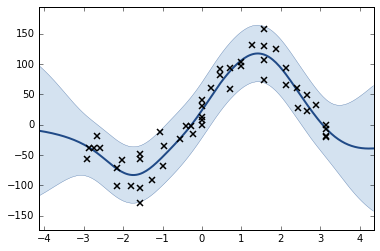

In [62]:
import GPy

def to_col(v): 
    return np.reshape(v, (v.size,1))

# XXX: rescaling?

# For visualization purposes, show GP fit to all measured data.
# We'll do some loo analysis later on
kernel = GPy.kern.Matern52(1, ARD=False, lengthscale=1.)
y = 1e3 * D[:,0]  # mm to microns
model = GPy.models.GPRegression(to_col(thetaN), to_col(y), kernel)
model.optimize(messages=True, max_f_eval=1000)

print model
model.plot()

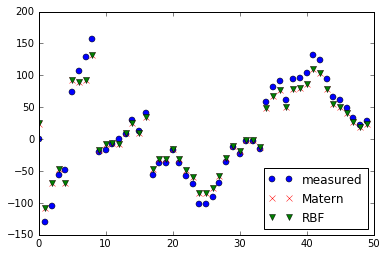

99.5953 100.105


In [63]:
# Compare a few kernels

ker1 = GPy.kern.Matern52(1, ARD=False, lengthscale=1.)
ker2 = GPy.kern.RBF(1, lengthscale=1.)

micronsToMM = 1e3
_x = thetaN
_y = micronsToMM*D[:,0]

err1, yHat1 = gpam.loo_err_1d(ker1, _x, _y)
err2, yHat2 = gpam.loo_err_1d(ker2, _x, _y)

plt.plot(np.arange(_y.size), _y, 'bo', 
         np.arange(_y.size), yHat1, 'rx',
         np.arange(_y.size), yHat2, 'gv')
plt.legend(['measured', 'Matern', 'RBF'], loc='lower right')
plt.show()

print err1, err2